# Generate Plots for METHODS_RESULTS_ANALYSIS Report

This notebook generates all publication-quality plots for the project report.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Output directory
PLOTS_DIR = Path('/scratch/gilbreth/sramishe/CS577_Project/QwQ_R1/plots')
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Plots will be saved to: {PLOTS_DIR}")

Plots will be saved to: /scratch/gilbreth/sramishe/CS577_Project/QwQ_R1/plots


## Load Data

In [2]:
# Load corrected analysis
fixed_df = pd.read_csv('/scratch/gilbreth/sramishe/results_QwQ_R1/results_improved/fixed_analysis.csv')

# Load full results
with open('/scratch/gilbreth/sramishe/results_QwQ_R1/results_improved/results_fixed.json', 'r') as f:
    results = json.load(f)

print(f"Loaded {len(fixed_df)} intervention results")
print(f"Layers tested: {sorted(fixed_df['layer'].unique())}")
print(f"Strengths tested: {sorted(fixed_df['strength'].unique())}")

Loaded 144 intervention results
Layers tested: [np.int64(0), np.int64(4), np.int64(8), np.int64(12), np.int64(16), np.int64(20), np.int64(24), np.int64(28), np.int64(32), np.int64(36), np.int64(40), np.int64(44), np.int64(48), np.int64(52), np.int64(56), np.int64(60)]
Strengths tested: [np.float64(-2.0), np.float64(-1.5), np.float64(-1.0), np.float64(-0.5), np.float64(0.0), np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0)]


## Plot 1: Evaluation Bug Impact

Shows how many results were affected by the truncation bug

✓ Saved: 1_evaluation_bug_impact.png


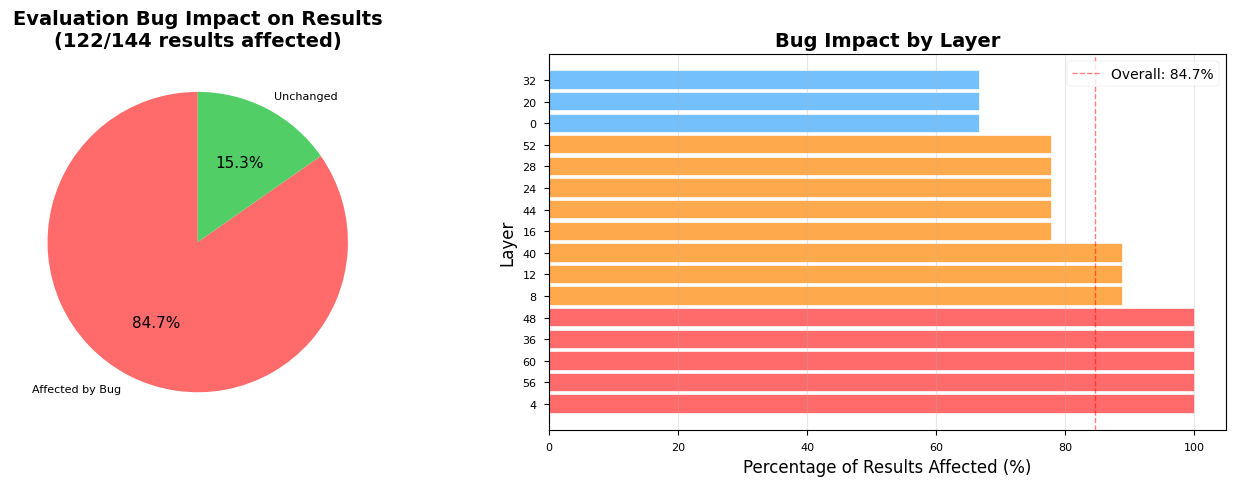

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall impact
bug_impact = fixed_df['changed'].value_counts()
colors = ['#ff6b6b', '#51cf66']
axes[0].pie(
    bug_impact.values,
    labels=['Affected by Bug', 'Unchanged'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
axes[0].set_title('Evaluation Bug Impact on Results\n(122/144 results affected)', fontweight='bold')

# Right: Changes by layer
layer_changes = fixed_df.groupby('layer')['changed'].apply(lambda x: (x.sum(), len(x)))
layer_changes_df = pd.DataFrame(
    [(layer, changed, total) for layer, (changed, total) in layer_changes.items()],
    columns=['Layer', 'Changed', 'Total']
)
layer_changes_df['Percent'] = 100 * layer_changes_df['Changed'] / layer_changes_df['Total']
layer_changes_df = layer_changes_df.sort_values('Percent', ascending=False)

bars = axes[1].barh(layer_changes_df['Layer'].astype(str), layer_changes_df['Percent'])
# Color code by severity
for i, (idx, row) in enumerate(layer_changes_df.iterrows()):
    if row['Percent'] == 100:
        bars[i].set_color('#ff6b6b')  # Red for 100%
    elif row['Percent'] >= 75:
        bars[i].set_color('#ffa94d')  # Orange for 75-99%
    else:
        bars[i].set_color('#74c0fc')  # Blue for <75%

axes[1].set_xlabel('Percentage of Results Affected (%)')
axes[1].set_ylabel('Layer')
axes[1].set_title('Bug Impact by Layer', fontweight='bold')
axes[1].axvline(84.7, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overall: 84.7%')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '1_evaluation_bug_impact.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 1_evaluation_bug_impact.png")
plt.show()

## Plot 2: Before vs After Bug Fix - Think Tokens Distribution

✓ Saved: 2_think_tokens_before_after.png


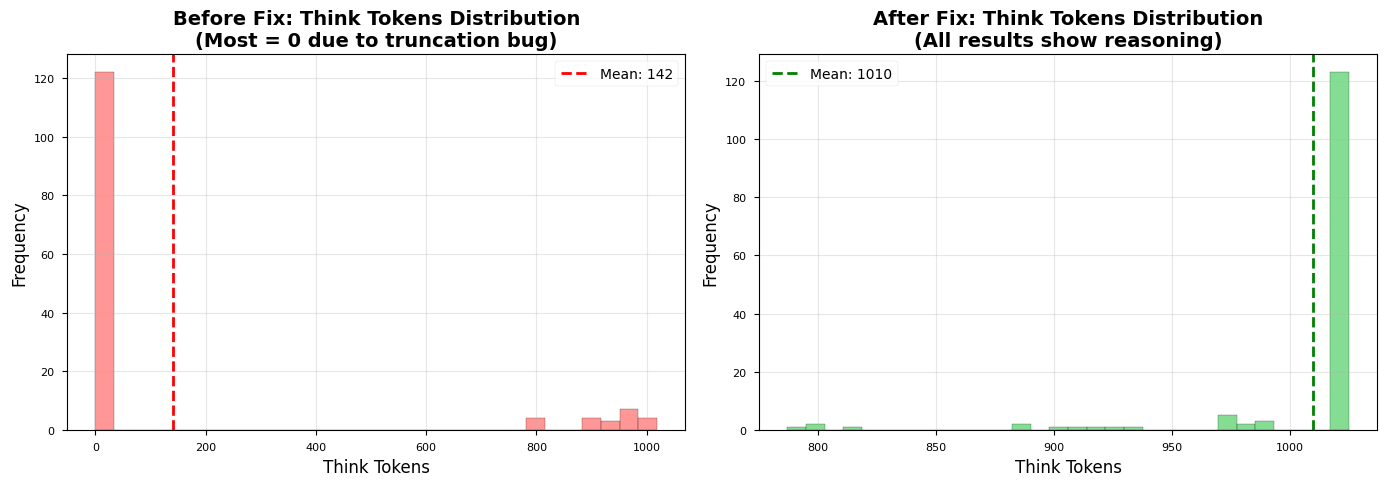

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of old think tokens
axes[0].hist(fixed_df['think_tokens_old'], bins=30, color='#ff6b6b', alpha=0.7, edgecolor='black')
axes[0].axvline(fixed_df['think_tokens_old'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {fixed_df["think_tokens_old"].mean():.0f}')
axes[0].set_xlabel('Think Tokens')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Before Fix: Think Tokens Distribution\n(Most = 0 due to truncation bug)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Histogram of new think tokens
axes[1].hist(fixed_df['think_tokens_new'], bins=30, color='#51cf66', alpha=0.7, edgecolor='black')
axes[1].axvline(fixed_df['think_tokens_new'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {fixed_df["think_tokens_new"].mean():.0f}')
axes[1].set_xlabel('Think Tokens')
axes[1].set_ylabel('Frequency')
axes[1].set_title('After Fix: Think Tokens Distribution\n(All results show reasoning)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '2_think_tokens_before_after.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 2_think_tokens_before_after.png")
plt.show()

## Plot 3: Layer Sensitivity - Token Count Range

✓ Saved: 3_layer_sensitivity_range.png


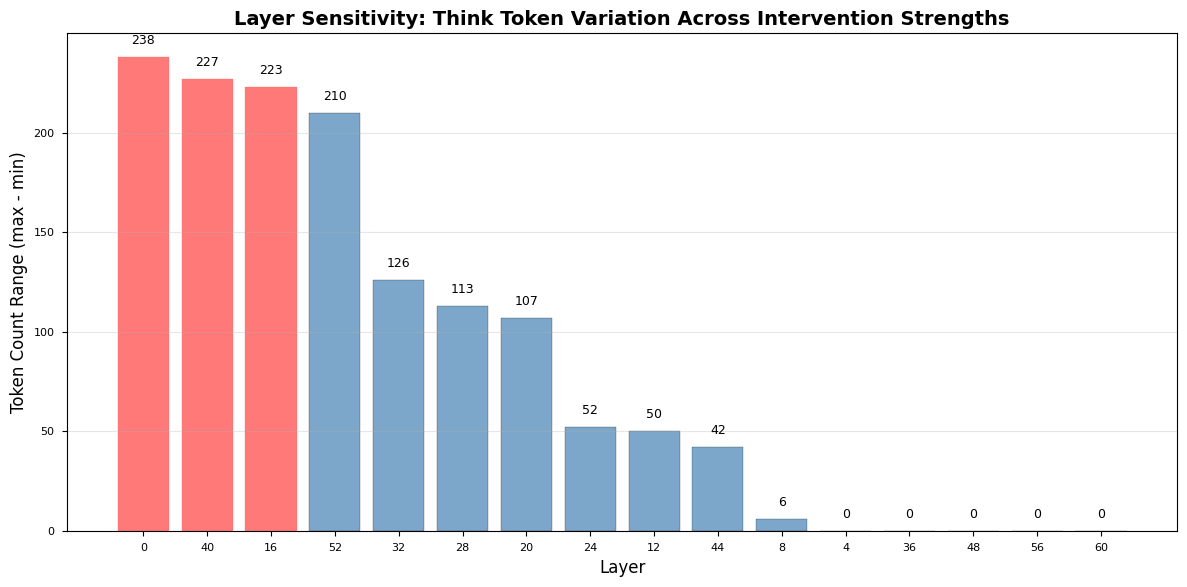


Top 3 Most Sensitive Layers:
       min   max        mean        std  range
layer                                         
0      787  1025  967.666667  90.441970    238
40     798  1025  999.777778  75.666667    227
16     802  1025  994.444444  74.187450    223


In [5]:
# Calculate token ranges per layer
layer_stats = fixed_df.groupby('layer')['think_tokens_new'].agg(['min', 'max', 'mean', 'std'])
layer_stats['range'] = layer_stats['max'] - layer_stats['min']
layer_stats = layer_stats.sort_values('range', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot with error bars
x = np.arange(len(layer_stats))
bars = ax.bar(x, layer_stats['range'], color='steelblue', alpha=0.7, edgecolor='black')

# Highlight top 3 most sensitive layers
for i in range(min(3, len(bars))):
    bars[i].set_color('#ff6b6b')
    bars[i].set_alpha(0.9)

ax.set_xlabel('Layer')
ax.set_ylabel('Token Count Range (max - min)')
ax.set_title('Layer Sensitivity: Think Token Variation Across Intervention Strengths', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(layer_stats.index, rotation=0)
ax.grid(axis='y', alpha=0.3)

# Add values on top of bars
for i, (idx, row) in enumerate(layer_stats.iterrows()):
    ax.text(i, row['range'] + 5, f"{row['range']:.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '3_layer_sensitivity_range.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 3_layer_sensitivity_range.png")
plt.show()

print("\nTop 3 Most Sensitive Layers:")
print(layer_stats.head(3))

## Plot 4: Heatmap - Think Tokens by Layer and Strength

✓ Saved: 4_heatmap_think_tokens.png


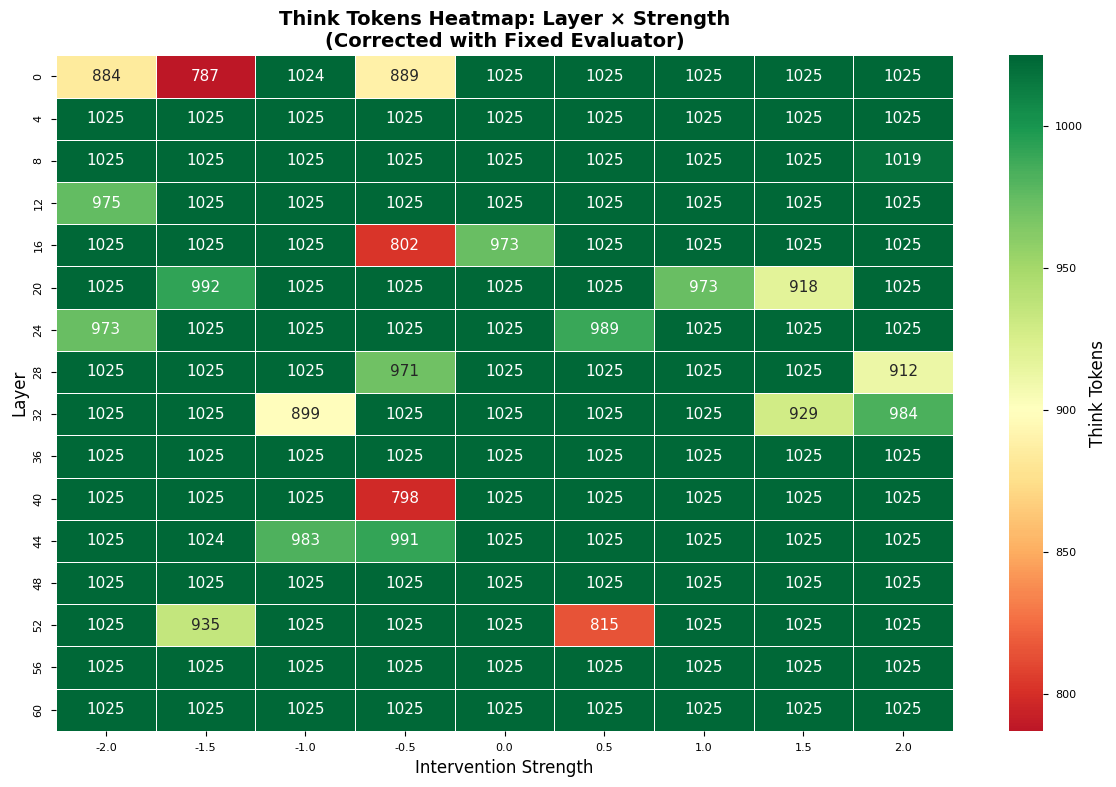

In [6]:
# Create pivot table
heatmap_data = fixed_df.pivot(index='layer', columns='strength', values='think_tokens_new')

fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn',
    center=900,  # Center colormap around typical value
    cbar_kws={'label': 'Think Tokens'},
    linewidths=0.5,
    ax=ax
)

ax.set_xlabel('Intervention Strength')
ax.set_ylabel('Layer')
ax.set_title('Think Tokens Heatmap: Layer × Strength\n(Corrected with Fixed Evaluator)', fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / '4_heatmap_think_tokens.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 4_heatmap_think_tokens.png")
plt.show()

## Plot 5: Reasoning Steps by Layer and Strength

✓ Saved: 5_heatmap_reasoning_steps.png


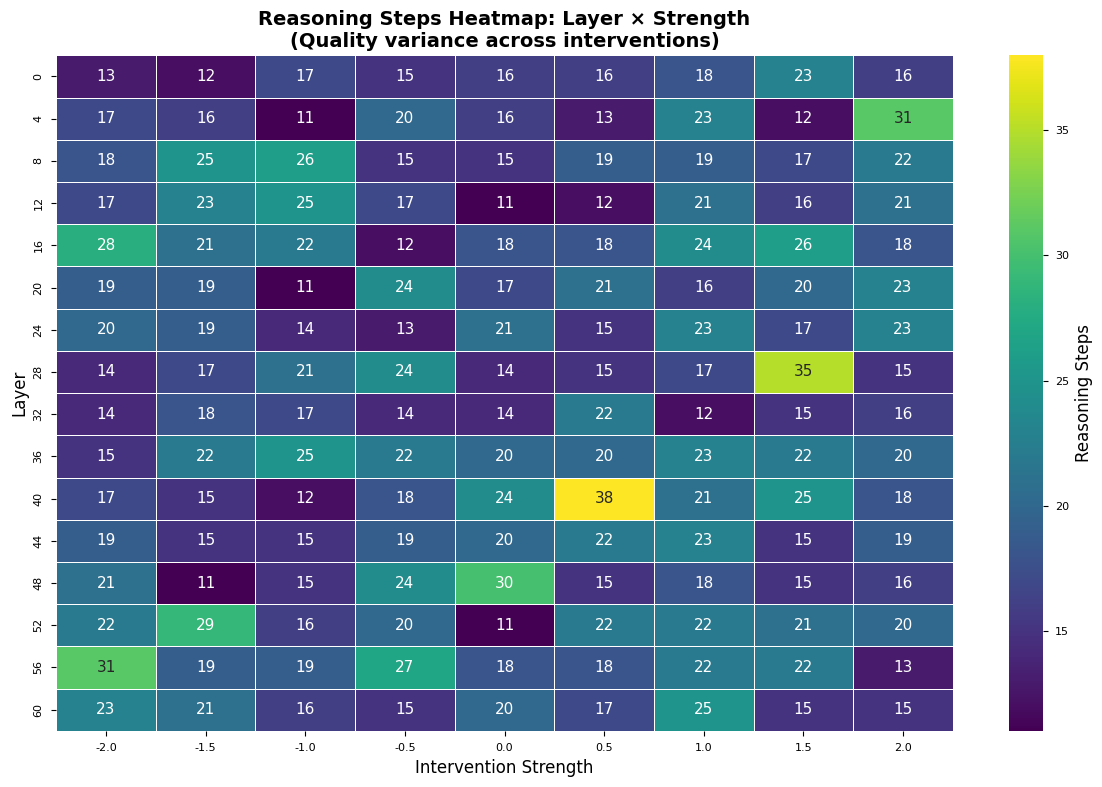

In [7]:
# Create pivot table for reasoning steps
steps_heatmap = fixed_df.pivot(index='layer', columns='strength', values='reasoning_steps_new')

fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    steps_heatmap,
    annot=True,
    fmt='.0f',
    cmap='viridis',
    cbar_kws={'label': 'Reasoning Steps'},
    linewidths=0.5,
    ax=ax
)

ax.set_xlabel('Intervention Strength')
ax.set_ylabel('Layer')
ax.set_title('Reasoning Steps Heatmap: Layer × Strength\n(Quality variance across interventions)', fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / '5_heatmap_reasoning_steps.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 5_heatmap_reasoning_steps.png")
plt.show()

## Plot 6: Layer-Specific Response Curves (Selected Layers)

✓ Saved: 6_layer_response_curves.png


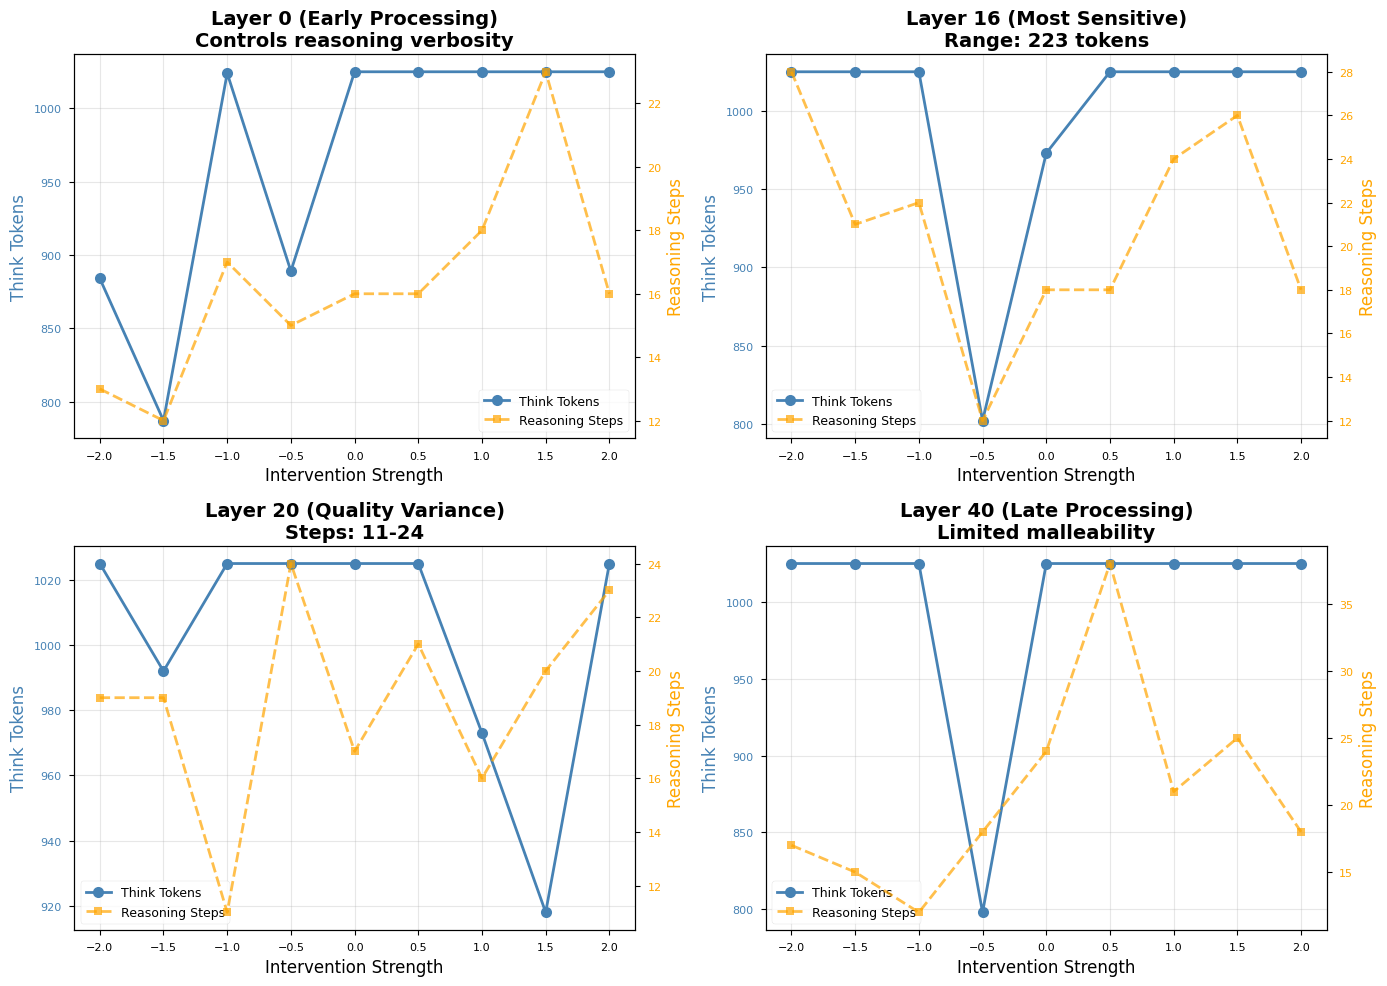

In [8]:
# Plot response curves for most interesting layers
interesting_layers = [0, 16, 20, 40]  # Early, most sensitive, quality variance, late

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, layer in enumerate(interesting_layers):
    layer_data = fixed_df[fixed_df['layer'] == layer].sort_values('strength')
    
    ax = axes[i]
    
    # Plot think tokens
    ax.plot(layer_data['strength'], layer_data['think_tokens_new'], 'o-', 
            color='steelblue', linewidth=2, markersize=8, label='Think Tokens')
    ax.set_xlabel('Intervention Strength')
    ax.set_ylabel('Think Tokens', color='steelblue')
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax.grid(alpha=0.3)
    
    # Add reasoning steps on secondary axis
    ax2 = ax.twinx()
    ax2.plot(layer_data['strength'], layer_data['reasoning_steps_new'], 's--',
             color='orange', linewidth=2, markersize=6, label='Reasoning Steps', alpha=0.7)
    ax2.set_ylabel('Reasoning Steps', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Title with layer-specific interpretation
    titles = {
        0: f'Layer {layer} (Early Processing)\nControls reasoning verbosity',
        16: f'Layer {layer} (Most Sensitive)\nRange: {layer_stats.loc[layer, "range"]:.0f} tokens',
        20: f'Layer {layer} (Quality Variance)\nSteps: {steps_heatmap.loc[layer].min():.0f}-{steps_heatmap.loc[layer].max():.0f}',
        40: f'Layer {layer} (Late Processing)\nLimited malleability'
    }
    ax.set_title(titles[layer], fontweight='bold')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '6_layer_response_curves.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 6_layer_response_curves.png")
plt.show()

## Plot 7: Reasoning Quality Variance by Layer

/tmp/ipykernel_970609/2223627461.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_for_box, labels=top_layers, patch_artist=True)


✓ Saved: 7_quality_variance.png


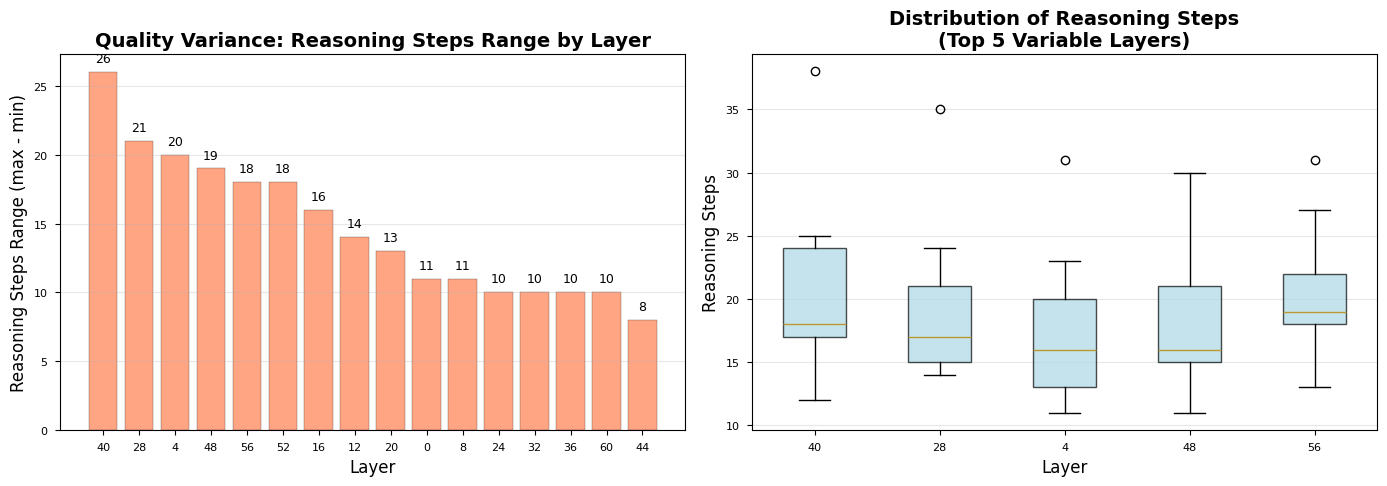


Top 5 Layers by Reasoning Quality Variance:
            mean       std  min  max        cv  range
layer                                                
40     20.888889  7.623064   12   38  0.364934     26
28     19.111111  6.845518   14   35  0.358196     21
4      17.666667  6.284903   11   31  0.355749     20
48     18.333333  5.787918   11   30  0.315705     19
56     21.000000  5.338539   13   31  0.254216     18


In [9]:
# Calculate coefficient of variation for reasoning steps
quality_var = fixed_df.groupby('layer')['reasoning_steps_new'].agg(['mean', 'std', 'min', 'max'])
quality_var['cv'] = quality_var['std'] / quality_var['mean']  # Coefficient of variation
quality_var['range'] = quality_var['max'] - quality_var['min']
quality_var = quality_var.sort_values('range', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Range of reasoning steps
x = np.arange(len(quality_var))
axes[0].bar(x, quality_var['range'], color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Reasoning Steps Range (max - min)')
axes[0].set_title('Quality Variance: Reasoning Steps Range by Layer', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(quality_var.index, rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add values
for i, (idx, row) in enumerate(quality_var.iterrows()):
    axes[0].text(i, row['range'] + 0.5, f"{row['range']:.0f}", ha='center', va='bottom', fontsize=9)

# Right: Box plot of top 5 layers
top_layers = quality_var.head(5).index.tolist()
data_for_box = [fixed_df[fixed_df['layer'] == layer]['reasoning_steps_new'].values for layer in top_layers]

bp = axes[1].boxplot(data_for_box, labels=top_layers, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Reasoning Steps')
axes[1].set_title('Distribution of Reasoning Steps\n(Top 5 Variable Layers)', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '7_quality_variance.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 7_quality_variance.png")
plt.show()

print("\nTop 5 Layers by Reasoning Quality Variance:")
print(quality_var.head())

## Plot 8: Intervention Effect Size by Strength

✓ Saved: 8_strength_effect_size.png


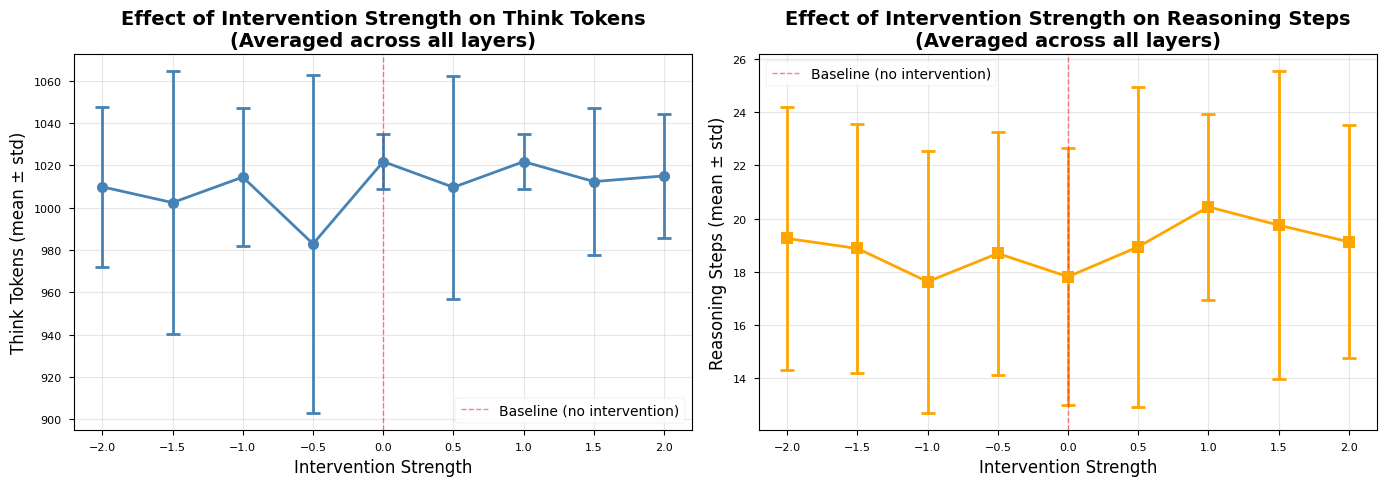

In [10]:
# Calculate mean and std for each strength across all layers
strength_stats = fixed_df.groupby('strength').agg({
    'think_tokens_new': ['mean', 'std'],
    'reasoning_steps_new': ['mean', 'std']
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Think tokens by strength
x = strength_stats.index
y = strength_stats[('think_tokens_new', 'mean')]
err = strength_stats[('think_tokens_new', 'std')]

axes[0].errorbar(x, y, yerr=err, fmt='o-', linewidth=2, markersize=8, 
                 capsize=5, capthick=2, color='steelblue')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Baseline (no intervention)')
axes[0].set_xlabel('Intervention Strength')
axes[0].set_ylabel('Think Tokens (mean ± std)')
axes[0].set_title('Effect of Intervention Strength on Think Tokens\n(Averaged across all layers)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Reasoning steps by strength  
y = strength_stats[('reasoning_steps_new', 'mean')]
err = strength_stats[('reasoning_steps_new', 'std')]

axes[1].errorbar(x, y, yerr=err, fmt='s-', linewidth=2, markersize=8,
                 capsize=5, capthick=2, color='orange')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Baseline (no intervention)')
axes[1].set_xlabel('Intervention Strength')
axes[1].set_ylabel('Reasoning Steps (mean ± std)')
axes[1].set_title('Effect of Intervention Strength on Reasoning Steps\n(Averaged across all layers)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '8_strength_effect_size.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 8_strength_effect_size.png")
plt.show()

## Plot 9: Complete vs Truncated Generations

✓ Saved: 9_truncation_analysis.png


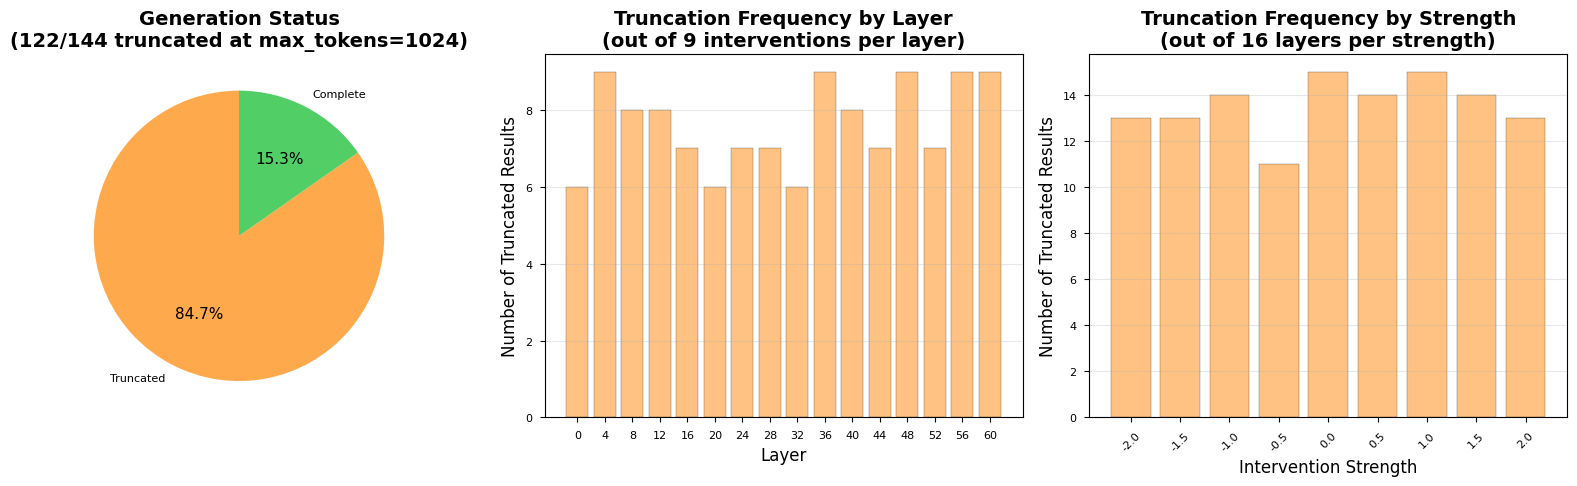

In [11]:
# Classify results as complete (<1024) or truncated (≥1024)
fixed_df['status'] = fixed_df['think_tokens_new'].apply(lambda x: 'Truncated' if x >= 1024 else 'Complete')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: Overall distribution
status_counts = fixed_df['status'].value_counts()
axes[0].pie(
    status_counts.values,
    labels=status_counts.index,
    autopct='%1.1f%%',
    colors=['#ffa94d', '#51cf66'],
    startangle=90
)
axes[0].set_title(f'Generation Status\n({status_counts["Truncated"]}/{len(fixed_df)} truncated at max_tokens=1024)', 
                  fontweight='bold')

# Middle: Truncation by layer
truncation_by_layer = fixed_df.groupby('layer')['status'].apply(lambda x: (x == 'Truncated').sum())
x = np.arange(len(truncation_by_layer))
bars = axes[1].bar(x, truncation_by_layer.values, color='#ffa94d', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Number of Truncated Results')
axes[1].set_title('Truncation Frequency by Layer\n(out of 9 interventions per layer)', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(truncation_by_layer.index, rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Right: Truncation by strength
truncation_by_strength = fixed_df.groupby('strength')['status'].apply(lambda x: (x == 'Truncated').sum())
axes[2].bar(range(len(truncation_by_strength)), truncation_by_strength.values, 
            color='#ffa94d', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Intervention Strength')
axes[2].set_ylabel('Number of Truncated Results')
axes[2].set_title('Truncation Frequency by Strength\n(out of 16 layers per strength)', fontweight='bold')
axes[2].set_xticks(range(len(truncation_by_strength)))
axes[2].set_xticklabels(truncation_by_strength.index, rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / '9_truncation_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 9_truncation_analysis.png")
plt.show()

## Plot 10: Summary Statistics Table (as Image)

✓ Saved: 10_summary_statistics.png


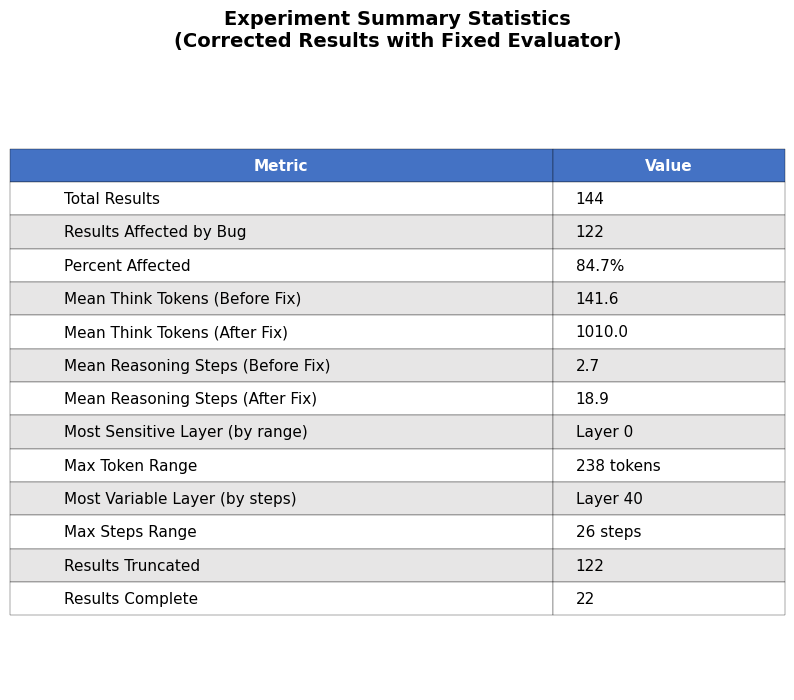

In [12]:
# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Results',
        'Results Affected by Bug',
        'Percent Affected',
        'Mean Think Tokens (Before Fix)',
        'Mean Think Tokens (After Fix)',
        'Mean Reasoning Steps (Before Fix)',
        'Mean Reasoning Steps (After Fix)',
        'Most Sensitive Layer (by range)',
        'Max Token Range',
        'Most Variable Layer (by steps)',
        'Max Steps Range',
        'Results Truncated',
        'Results Complete'
    ],
    'Value': [
        len(fixed_df),
        fixed_df['changed'].sum(),
        f"{100*fixed_df['changed'].sum()/len(fixed_df):.1f}%",
        f"{fixed_df['think_tokens_old'].mean():.1f}",
        f"{fixed_df['think_tokens_new'].mean():.1f}",
        f"{fixed_df['reasoning_steps_old'].mean():.1f}",
        f"{fixed_df['reasoning_steps_new'].mean():.1f}",
        f"Layer {layer_stats.index[0]}",
        f"{layer_stats['range'].max():.0f} tokens",
        f"Layer {quality_var.index[0]}",
        f"{quality_var['range'].max():.0f} steps",
        (fixed_df['status'] == 'Truncated').sum(),
        (fixed_df['status'] == 'Complete').sum()
    ]
})

# Create figure with table
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_stats.values,
    colLabels=summary_stats.columns,
    cellLoc='left',
    loc='center',
    colWidths=[0.7, 0.3]
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header
for i in range(len(summary_stats.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(summary_stats) + 1):
    if i % 2 == 0:
        table[(i, 0)].set_facecolor('#E7E6E6')
        table[(i, 1)].set_facecolor('#E7E6E6')

ax.set_title('Experiment Summary Statistics\n(Corrected Results with Fixed Evaluator)', 
             fontsize=14, fontweight='bold', pad=20)

plt.savefig(PLOTS_DIR / '10_summary_statistics.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: 10_summary_statistics.png")
plt.show()

## Summary

In [13]:
print("\n" + "="*80)
print("ALL PLOTS GENERATED SUCCESSFULLY")
print("="*80)
print(f"\nPlots saved to: {PLOTS_DIR}")
print("\nGenerated plots:")
for i, plot_file in enumerate(sorted(PLOTS_DIR.glob('*.png')), 1):
    print(f"  {i}. {plot_file.name}")

print("\n" + "="*80)
print("SUGGESTED PLOTS FOR REPORT:")
print("="*80)
print("""
1. Methods Section:
   - 10_summary_statistics.png (Experiment overview)

2. Evaluation Bug Section:
   - 1_evaluation_bug_impact.png (Bug impact visualization)
   - 2_think_tokens_before_after.png (Distribution shift)

3. Results Section:
   - 4_heatmap_think_tokens.png (Main results overview)
   - 5_heatmap_reasoning_steps.png (Quality metrics)
   - 3_layer_sensitivity_range.png (Layer comparison)

4. Analysis Section:
   - 6_layer_response_curves.png (Detailed layer analysis)
   - 7_quality_variance.png (Quality variation)
   - 8_strength_effect_size.png (Intervention effects)

5. Limitations Section:
   - 9_truncation_analysis.png (Truncation impact)
""")


ALL PLOTS GENERATED SUCCESSFULLY

Plots saved to: /scratch/gilbreth/sramishe/CS577_Project/QwQ_R1/plots

Generated plots:
  1. 10_summary_statistics.png
  2. 1_evaluation_bug_impact.png
  3. 2_think_tokens_before_after.png
  4. 3_layer_sensitivity_range.png
  5. 4_heatmap_think_tokens.png
  6. 5_heatmap_reasoning_steps.png
  7. 6_layer_response_curves.png
  8. 7_quality_variance.png
  9. 8_strength_effect_size.png
  10. 9_truncation_analysis.png

SUGGESTED PLOTS FOR REPORT:

1. Methods Section:
   - 10_summary_statistics.png (Experiment overview)

2. Evaluation Bug Section:
   - 1_evaluation_bug_impact.png (Bug impact visualization)
   - 2_think_tokens_before_after.png (Distribution shift)

3. Results Section:
   - 4_heatmap_think_tokens.png (Main results overview)
   - 5_heatmap_reasoning_steps.png (Quality metrics)
   - 3_layer_sensitivity_range.png (Layer comparison)

4. Analysis Section:
   - 6_layer_response_curves.png (Detailed layer analysis)
   - 7_quality_variance.png (Qualit